In [17]:
# data analysis and wrangling
import pandas as pd
import numpy as np

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4


# machine learning
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection, preprocessing
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV


//anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
//anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [18]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
macro = pd.read_csv('macro.csv')
id_test = test_df.id
train_df.sample(3)
#train_df.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
2516,2519,2012-06-15,33,18.0,1.0,NaN,NaN,NaN,NaN,NaN,...,16,3,0,15,30,1,10,62,14,5700000
7968,7971,2013-05-16,38,17.0,15.0,NaN,NaN,NaN,NaN,NaN,...,2,1,0,2,7,1,0,20,3,5500000
5525,5528,2012-12-27,58,NaN,19.0,NaN,NaN,NaN,NaN,NaN,...,1,1,0,1,7,0,0,6,0,5298383


In [19]:
print(train_df.columns.values)

['id' 'timestamp' 'full_sq' 'life_sq' 'floor' 'max_floor' 'material'
 'build_year' 'num_room' 'kitch_sq' 'state' 'product_type' 'sub_area'
 'area_m' 'raion_popul' 'green_zone_part' 'indust_part'
 'children_preschool' 'preschool_quota' 'preschool_education_centers_raion'
 'children_school' 'school_quota' 'school_education_centers_raion'
 'school_education_centers_top_20_raion' 'hospital_beds_raion'
 'healthcare_centers_raion' 'university_top_20_raion' 'sport_objects_raion'
 'additional_education_raion' 'culture_objects_top_25'
 'culture_objects_top_25_raion' 'shopping_centers_raion' 'office_raion'
 'thermal_power_plant_raion' 'incineration_raion' 'oil_chemistry_raion'
 'radiation_raion' 'railroad_terminal_raion' 'big_market_raion'
 'nuclear_reactor_raion' 'detention_facility_raion' 'full_all' 'male_f'
 'female_f' 'young_all' 'young_male' 'young_female' 'work_all' 'work_male'
 'work_female' 'ekder_all' 'ekder_male' 'ekder_female' '0_6_all' '0_6_male'
 '0_6_female' '7_14_all' '7_14_male' 

In [20]:
train_df.shape

(30471, 292)

In [21]:
null_num = train_df.isnull().sum()

In [22]:
type(null_num)

pandas.core.series.Series

In [23]:
#null_num.to_csv('nullnum.csv')

In [24]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30471 entries, 0 to 30470
Columns: 292 entries, id to price_doc
dtypes: float64(119), int64(157), object(16)
memory usage: 67.9+ MB


In [25]:
for f in train_df.columns:
    if train_df[f].dtype=='object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_df[f].values)) 
        train_df[f] = lbl.transform(list(train_df[f].values))

In [26]:
#將object類型的data轉為int
for f in test_df.columns:
    if test_df[f].dtype=='object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(test_df[f].values)) 
        test_df[f] = lbl.transform(list(test_df[f].values))

In [27]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30471 entries, 0 to 30470
Columns: 292 entries, id to price_doc
dtypes: float64(119), int64(173)
memory usage: 67.9 MB


In [28]:
#from collections import Counter
#Counter(train_df.full_sq)

In [29]:
Y_train = train_df["price_doc"]
X_train = train_df.drop(["id", "timestamp", "price_doc"], axis=1)
X_test = test_df.drop(["id", "timestamp"], axis=1)

In [30]:
X_train.shape

(30471, 289)

In [42]:
global num_boost_rounds

In [43]:
def modelfit(alg, X_train, Y_train, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train, Y_train)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          metrics='rmse',verbose_eval=50, show_stdv=False, early_stopping_rounds=early_stopping_rounds)
        #alg.set_params(n_estimators=cvresult.shape[0])
        global num_boost_rounds
        num_boost_rounds = len(cvresult)
        print(num_boost_rounds)
        cvresult[['train-rmse-mean', 'test-rmse-mean']].plot()
        plt.show()
        

    #Fit the algorithm on the data
#     alg.fit(X_train, Y_train, eval_metric='rmse')

#     #Predict training set:
#     dtrain_predictions = alg.predict(X_train)
#     dtrain_predprob = alg.predict_proba(X_train)[:,1]

#     #Print model report:
#     print("\nModel Report")
#     print("RMSE : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions))
#     print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))

#     feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
#     feat_imp.plot(kind='bar', title='Feature Importances')
#     plt.ylabel('Feature Importance Score')

[0]	train-rmse:8.19764e+06	test-rmse:8.20903e+06
[50]	train-rmse:2.065e+06	test-rmse:2.8047e+06
[100]	train-rmse:1.66532e+06	test-rmse:2.65816e+06
[150]	train-rmse:1.52046e+06	test-rmse:2.63669e+06
[200]	train-rmse:1.41866e+06	test-rmse:2.6317e+06
[250]	train-rmse:1.32848e+06	test-rmse:2.63133e+06
242


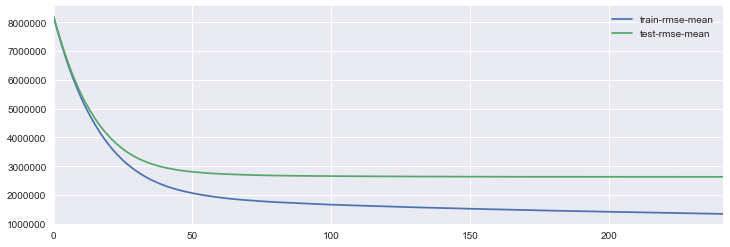

In [44]:
xgb1 = XGBRegressor(
 learning_rate =0.05,
 n_estimators=1000,
 max_depth=8,
 min_child_weight=1,
 gamma=0,
 subsample=0.7,
 colsample_bytree=0.7,
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, X_train, Y_train)

## Tune max_depth and min_child_weight

In [53]:
param_test1 = {
 'max_depth': list(range(3,10,2)),
 'min_child_weight':list(range(1,6,2))
}
gsearch1 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.05, n_estimators=242, max_depth=8,
 min_child_weight=1, gamma=0, subsample=0.7, colsample_bytree=0.7,
 objective='reg:linear', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train,Y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: -7977241953444.21094, std: 1393718300781.93433, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: -7981912518615.99414, std: 1424082575276.74097, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: -7984930795029.23438, std: 1436736951927.68945, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: -7634001860833.23438, std: 1491628509315.78271, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: -7590187808922.97852, std: 1512864380975.81104, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: -7591986180610.70605, std: 1596437146137.74634, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: -7589377444503.60645, std: 1516326676242.50830, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: -7522606408589.61426, std: 1518660789097.44629, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: -7523893417909.84961, std: 1585843907108.45166, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: -7684939589283.65820, std: 1455202150595.96436,

In [56]:
param_test2 = {
 'max_depth': [6,7,8],
 'min_child_weight':[2,3,4]
}
gsearch2 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.05, n_estimators=242, max_depth=8,
 min_child_weight=1, gamma=0, subsample=0.7, colsample_bytree=0.7,
 objective='reg:linear', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test2, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train,Y_train)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: -7558862111419.89844, std: 1521363839547.54346, params: {'max_depth': 6, 'min_child_weight': 2},
  mean: -7580939678561.29492, std: 1589649885149.69360, params: {'max_depth': 6, 'min_child_weight': 3},
  mean: -7587624392629.32031, std: 1495890716512.17798, params: {'max_depth': 6, 'min_child_weight': 4},
  mean: -7539702150563.04102, std: 1478939000111.84790, params: {'max_depth': 7, 'min_child_weight': 2},
  mean: -7522606408589.61426, std: 1518660789097.44629, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: -7541581320353.71875, std: 1559608392188.98682, params: {'max_depth': 7, 'min_child_weight': 4},
  mean: -7630224054467.95605, std: 1437583959125.31860, params: {'max_depth': 8, 'min_child_weight': 2},
  mean: -7564159429076.38086, std: 1452630972815.01099, params: {'max_depth': 8, 'min_child_weight': 3},
  mean: -7593971225711.42188, std: 1444481416103.58398, params: {'max_depth': 8, 'min_child_weight': 4}],
 {'max_depth': 7, 'min_child_weight': 3},
 -7522606408

## Tune gamma

In [58]:
param_test3 = {
    'gamma':[i/10.0 for i in range(0,8)]
}
gsearch3 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.05, n_estimators=242, max_depth=7,
 min_child_weight=3, gamma=0, subsample=0.7, colsample_bytree=0.7,
 objective='reg:linear', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test3, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_train,Y_train)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: -7522606408589.61426, std: 1518660789097.44629, params: {'gamma': 0.0},
  mean: -7522606408589.61426, std: 1518660789097.44629, params: {'gamma': 0.1},
  mean: -7522606408589.61426, std: 1518660789097.44629, params: {'gamma': 0.2},
  mean: -7522606408589.61426, std: 1518660789097.44629, params: {'gamma': 0.3},
  mean: -7522606408589.61426, std: 1518660789097.44629, params: {'gamma': 0.4},
  mean: -7522606408589.61426, std: 1518660789097.44629, params: {'gamma': 0.5},
  mean: -7522606408589.61426, std: 1518660789097.44629, params: {'gamma': 0.6},
  mean: -7522606408589.61426, std: 1518660789097.44629, params: {'gamma': 0.7}],
 {'gamma': 0.0},
 -7522606408589.614)

## Tune subsample and colsample_bytree

In [59]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.05, n_estimators=242, max_depth=7,
 min_child_weight=3, gamma=0, subsample=0.7, colsample_bytree=0.7,
 objective='reg:linear', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test4, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch4.fit(X_train,Y_train)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: -7457834064494.81738, std: 1362752547611.50562, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: -7497160273164.74023, std: 1352561064335.85474, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: -7513928923392.65918, std: 1473742580681.12451, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: -7509908645728.12012, std: 1375577888630.25537, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: -7527631072539.17480, std: 1504529533240.50293, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: -7522606408589.61426, std: 1518660789097.44629, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: -7533432580018.53613, std: 1532141395559.54614, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: -7514577935567.58008, std: 1537392940063.49097, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: -7464533616028.06543, std: 1592242675357.73413, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: -7495338212

In [60]:
param_test5 = {
 'subsample':[i/100.0 for i in range(55,70,5)],
 'colsample_bytree':[i/100.0 for i in range(55,70,5)]
}
gsearch5 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.05, n_estimators=242, max_depth=7,
 min_child_weight=3, gamma=0, subsample=0.7, colsample_bytree=0.7,
 objective='reg:linear', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test5, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch5.fit(X_train,Y_train)
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: -7539074758880.35352, std: 1468777995344.01855, params: {'colsample_bytree': 0.55, 'subsample': 0.55},
  mean: -7492170797736.55762, std: 1378560109677.54980, params: {'colsample_bytree': 0.55, 'subsample': 0.6},
  mean: -7449238327660.70312, std: 1459739040781.73511, params: {'colsample_bytree': 0.55, 'subsample': 0.65},
  mean: -7492994247152.66602, std: 1412793530766.41675, params: {'colsample_bytree': 0.6, 'subsample': 0.55},
  mean: -7457834064494.81738, std: 1362752547611.50562, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: -7427356279758.30273, std: 1406735052118.79370, params: {'colsample_bytree': 0.6, 'subsample': 0.65},
  mean: -7475378818413.48438, std: 1430395511619.14087, params: {'colsample_bytree': 0.65, 'subsample': 0.55},
  mean: -7518857990226.75586, std: 1388342813527.86963, params: {'colsample_bytree': 0.65, 'subsample': 0.6},
  mean: -7546918433275.73730, std: 1443118334099.31934, params: {'colsample_bytree': 0.65, 'subsample': 0.65}],
 {'col

## Tuning Regularization Parameters

In [63]:
param_test6 = {
    'reg_alpha':[1e-2, 0.1, 1, 100],
    'reg_lambda':[1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.05, n_estimators=242, max_depth=7,
 min_child_weight=3, gamma=0, subsample=0.65, colsample_bytree=0.6,
 objective='reg:linear', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test6, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch6.fit(X_train,Y_train)
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

([mean: -7513389679623.19727, std: 1399673170371.69116, params: {'reg_alpha': 0.01, 'reg_lambda': 0.01},
  mean: -7582851223126.97461, std: 1406872851975.17920, params: {'reg_alpha': 0.01, 'reg_lambda': 0.1},
  mean: -7427356256010.65625, std: 1406735065876.91089, params: {'reg_alpha': 0.01, 'reg_lambda': 1},
  mean: -7612687987337.97852, std: 1350821945533.87134, params: {'reg_alpha': 0.01, 'reg_lambda': 100},
  mean: -7513389699363.08887, std: 1399673172137.66968, params: {'reg_alpha': 0.1, 'reg_lambda': 0.01},
  mean: -7582851215233.85156, std: 1406872821676.61499, params: {'reg_alpha': 0.1, 'reg_lambda': 0.1},
  mean: -7427356282668.80664, std: 1406735054375.45581, params: {'reg_alpha': 0.1, 'reg_lambda': 1},
  mean: -7612687988642.97168, std: 1350821945766.57812, params: {'reg_alpha': 0.1, 'reg_lambda': 100},
  mean: -7513389717951.01758, std: 1399673194584.03320, params: {'reg_alpha': 1, 'reg_lambda': 0.01},
  mean: -7582851209002.72852, std: 1406872824835.60059, params: {'reg_al

[0]	train-rmse:8.50267e+06	test-rmse:8.50333e+06
[50]	train-rmse:5.6377e+06	test-rmse:5.73041e+06
[100]	train-rmse:3.97922e+06	test-rmse:4.18756e+06
[150]	train-rmse:3.0562e+06	test-rmse:3.38752e+06
[200]	train-rmse:2.56102e+06	test-rmse:3.00281e+06
[250]	train-rmse:2.29164e+06	test-rmse:2.82236e+06
[300]	train-rmse:2.13895e+06	test-rmse:2.73616e+06
[350]	train-rmse:2.04446e+06	test-rmse:2.69113e+06
[400]	train-rmse:1.97892e+06	test-rmse:2.66476e+06
[450]	train-rmse:1.93011e+06	test-rmse:2.64852e+06
[500]	train-rmse:1.89094e+06	test-rmse:2.63767e+06
[550]	train-rmse:1.8573e+06	test-rmse:2.62917e+06
[600]	train-rmse:1.82733e+06	test-rmse:2.62171e+06
[650]	train-rmse:1.80005e+06	test-rmse:2.61619e+06
[700]	train-rmse:1.77658e+06	test-rmse:2.6125e+06
[750]	train-rmse:1.75443e+06	test-rmse:2.60876e+06
[800]	train-rmse:1.73205e+06	test-rmse:2.60599e+06
[850]	train-rmse:1.71177e+06	test-rmse:2.60317e+06
[900]	train-rmse:1.69177e+06	test-rmse:2.60123e+06
[950]	train-rmse:1.67357e+06	test-rmse

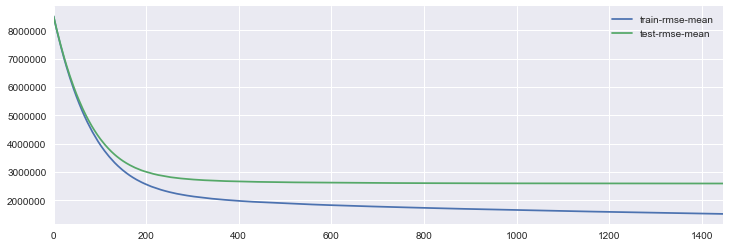

In [65]:
xgb2 = XGBRegressor(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=7,
 min_child_weight=3,
 gamma=0,
 subsample=0.65,
 colsample_bytree=0.6,
 nthread=4,
 scale_pos_weight=1,
 reg_alpha=100,
 reg_lambda=1,
 seed=27)
modelfit(xgb2, X_train, Y_train)

In [66]:
dtrain = xgb.DMatrix(X_train, Y_train)
dtest = xgb.DMatrix(X_test)

In [67]:
#num_boost_rounds = len(cv_output)
num_boost_rounds

1447

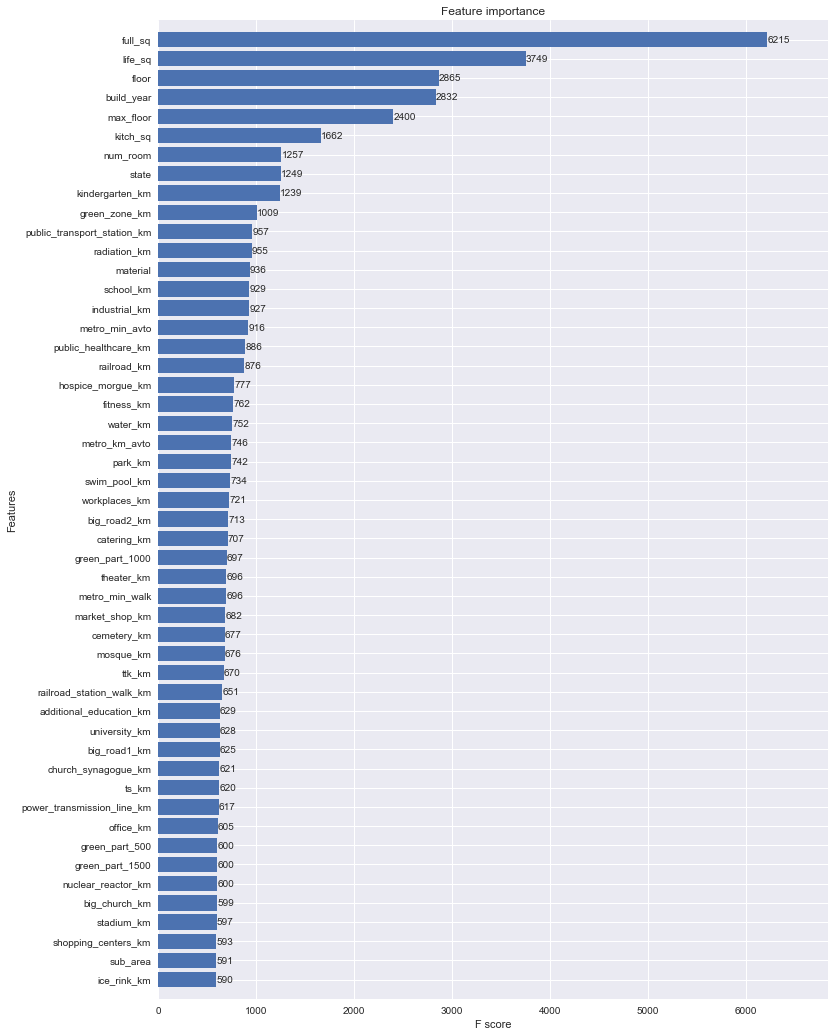

In [69]:
model = xgb.train(xgb2.get_xgb_params(), dtrain, num_boost_round= num_boost_rounds)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [70]:
preds = model.predict(dtest)

In [71]:
output = pd.DataFrame({'id': id_test, 'price_doc': preds})
output.head()

,id,price_doc
0,30474,5533859.0
1,30475,8422796.0
2,30476,5589342.0
3,30477,5966715.0
4,30478,5217587.5


In [72]:
output.to_csv('xgb_v6.csv', index=False)

In [ ]:
#75 31964
#100 31912 
#120 31897 *
#217 ?????